In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = 'True'
os.environ["OMP_NUM_THREADS"] = "1" #set cores for numpy
import numpy as np
import pandas as pd
import tensorflow as tf
import json
tf.get_logger().setLevel('ERROR') #no info and warnings are printed
tf.config.threading.set_inter_op_parallelism_threads(1) #set cores for TF
tf.config.threading.set_intra_op_parallelism_threads(1)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
# tf.config.set_visible_devices([], 'GPU') #runs the code without GPU
%matplotlib inline
import matplotlib.pyplot as plt
import h5py
import time
from pathlib import Path
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
sns.set(style='whitegrid')
from sklearn.metrics import mean_squared_error

#Latex
mpl.rc('text', usetex = False)
mpl.rc('font', family = 'serif')

# set random seed
SEED = 1024
tf.random.set_seed(SEED)
np.random.seed(SEED)
#random.seed(SEED)

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2025-03-10 11:08:06.381446: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-10 11:08:06.402503: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-10 11:08:06.402804: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


In [22]:
# load data
"""
U0 = np.load('velocityDataRe150v24_fluc.npy')
print('data has loaded successfully.')
U = U0[1:,:-1,:-1,0:2]
print('U-shape:',U.shape)
U_test = U[-400:]#[::2]
print('U_test.shape: ', U_test.shape)
"""


U_test = np.load('velocityDataRe150v24Valid_fluc.npy')
U_test = U_test[:,:-1,:-1,0:2]
print('U_test.shape: ', U_test.shape)


U_test.shape:  (200, 176, 144, 2)


In [3]:
# load saved model
N_latent = 1
N_parallel = 3
ker_size = [(3,3), (5,5), (7,7)]     #kernel sizes
path = './data_fluctuation/Re150_176x144x2_'+str(N_latent) #saved model's path
a = [None]*N_parallel
b = [None]*N_parallel
for i in range(N_parallel):
    a[i] = tf.keras.models.load_model(path + '/enc_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5')
                                          # , custom_objects={"SymPad2D": SymPad2D})
for i in range(N_parallel):
    b[i] = tf.keras.models.load_model(path + '/dec_mod'+str(ker_size[i])+'_'+str(N_latent)+'.h5')
                                          # , custom_objects={"SymPad2D": SymPad2D})


2025-03-10 11:08:40.093438: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-10 11:08:40.093929: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-10 11:08:40.094219: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-03-10 11:08:40.094457: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built witho

In [4]:
# define some model function

# inatial model
def model(inputs, enc_mods, dec_mods, is_train=False):

    '''
    Multiscale autoencoder.
    The contribution of the CNNs at different scales are simply summed.
    '''

    # sum of the contributions of the different CNNs
    encoded = 0
    for enc_mod in enc_mods:
        encoded += enc_mod(inputs, training=is_train)


    decoded = 0
    for dec_mod in dec_mods:
        decoded += dec_mod(encoded, training=is_train)

    return encoded, decoded


# get latent space data
def get_latent(input_data, encoders):
    enc_sum = 0
    for enc in encoders:
        enc_output = enc(input_data)
        enc_sum += enc_output

    return enc_sum.numpy()


# get reconstructed velocity fields from latent space data
def get_reconstruct(latent_data, decoders):

    decoder_outputs = []
    
    for decoder in decoders:
        decoder_output = decoder(latent_data)
        decoder_outputs.append(decoder_output.numpy())

    reconstruct = np.zeros(decoder_outputs[0].shape)
    reconstruct = decoder_outputs[0] + decoder_outputs[1] + decoder_outputs[2]

    return decoder_outputs, reconstruct


# get decoders outputs from initial velocity field
def get_decoders_output(u, enc_mods, dec_mods):
    encoded_sum = 0
    for enc_mod in enc_mods:
        encoded_output = enc_mod(u)
        encoded_sum += encoded_output

    dec_outputs = []

    for dec_mod in dec_mods:
        dec_output = dec_mod(encoded_sum)
        dec_outputs.append(dec_output.numpy())

    reconstruct = np.zeros(dec_outputs[0].shape)
    for i, dec_output in enumerate(dec_outputs):
        reconstruct += dec_output
    
    return dec_outputs, reconstruct


In [49]:
# define some postProcess function

# plot velocity field
# u should have shape of [176,144], c is colorbar label, filename is filename, all parameters needed.
def plot_contour(u, c='u', filename='test.pdf'):

    x_min, x_max, x_step = -0.25, 0.85, 0.00625
    y_min, y_max, y_step = -0.45, 0.45, 0.00625

    x_grid = np.arange(x_min, x_max, x_step)
    y_grid = np.arange(y_min, y_max, y_step)
    x_mesh, y_mesh = np.meshgrid(x_grid, y_grid, indexing='ij')
    
    #plt.rcParams["font.size"] = 12
    fig, ax = plt.subplots(figsize=(8,6))
    im = ax.contourf(x_mesh, y_mesh, u, levels=10, cmap='viridis') # viridis, plasma, inferno, magma, cividis
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label(c, labelpad=10, fontsize=14)
    cbar.ax.tick_params(labelsize=12)
    #CS = ax.contour(x_mesh, y_mesh, u, levels=8, colors='black', linewidths=.5, linestyles='solid')
        
    mask_x = (x_mesh >= -0.05) & (x_mesh <= 0.05)
    mask_y = (y_mesh >= -0.05) & (y_mesh <= 0.05)
    mask = mask_x & mask_y
    # 填充白色遮挡
    ax.contourf(x_mesh, y_mesh, mask, levels=[0.5, 1.5], colors='white', alpha=1)  # alpha 控制透明度

    ax.set_aspect('equal')
    #ax.text(1.5, 0.5, c, transform=cax.transAxes, ha='left', va='center', fontsize=10, rotation=90)
    ax.axis('off')
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()

# pod function
def POD_SVD(inputdata, components=10):
    t, ux, uy, dim = inputdata.shape
    data = inputdata.reshape(t,-1)
    data = data.T
    n = data.shape[0]
    m = data.shape[1]
    #mean = np.mean(data, axis=1)
    #x = data - mean[:, np.newaxis]
    x = data.copy()
    
    U, s, VT = np.linalg.svd(x, full_matrices=False)

    Ds = np.square(s)

    if components > m :
        print('!Error: components is greater than data.shape[1].')
        return

    phi = U[:, :components]
    An = np.diag(s).dot(VT)
    #reconstructed_data = phi.dot(An[:components, :]) + mean[:, np.newaxis]
    reconstructed_data = phi.dot(An[:components, :])
    reconstructed_error = mean_squared_error(data, reconstructed_data)

    phi = phi.T
    mode = phi.reshape(components, ux, uy, dim)

    reconstructed_data = reconstructed_data.T
    reconstructed_data = reconstructed_data.reshape(t, ux, uy, dim)

    #mean = mean.reshape(ux, uy, dim)

    #return components, reconstructed_error, reconstructed_data, mean, Ds, mode
    return components, reconstructed_error, reconstructed_data, Ds, mode, An[:components, :].T

# energy percentage
def ek(reconstruct, initial):
    ep = np.zeros(reconstruct.shape[0])
    for i in range(reconstruct.shape[0]):
        ep[i] = np.sum((reconstruct[i]-initial[i])**2) / np.sum(initial[i]**2)

    ek = 1 - np.mean(ep)
    return ek

# heatmap, data has shape of [length, modesNumber], annotion should be True or False 
def plot_heatmap(data, annotion, filename='test.pdf'):
    df = pd.DataFrame(data, columns=[f'{i+1}' for i in range(data.shape[1])])
    correlation_matrix = df.corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(correlation_matrix, annot=annotion, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink":0.8})
    #plt.title("Correlation Matrix HeatMap")
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

# frequency analysis
def freqSpectrum(data):
    fft_result = np.fft.fft(data)
    fft_freq = np.fft.fftfreq(len(data), d=0.025)
    positive_freq = fft_freq[:len(fft_freq)//2]
    positive_mag = np.abs(fft_result[:len(fft_result)//2])

    max_index = np.argmax(positive_mag)
    dominant_frequency = positive_freq[max_index]
    print(f"Dominant Frequency: {dominant_frequency} Hz")
    return positive_freq, positive_mag, dominant_frequency


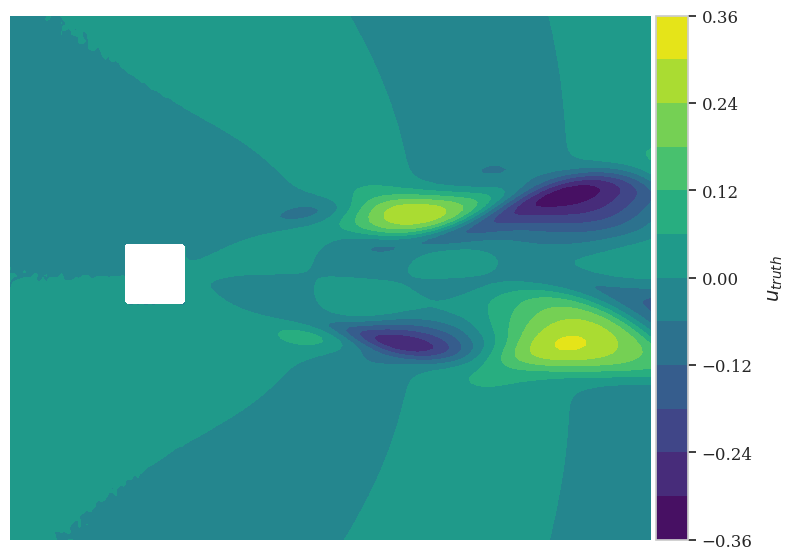

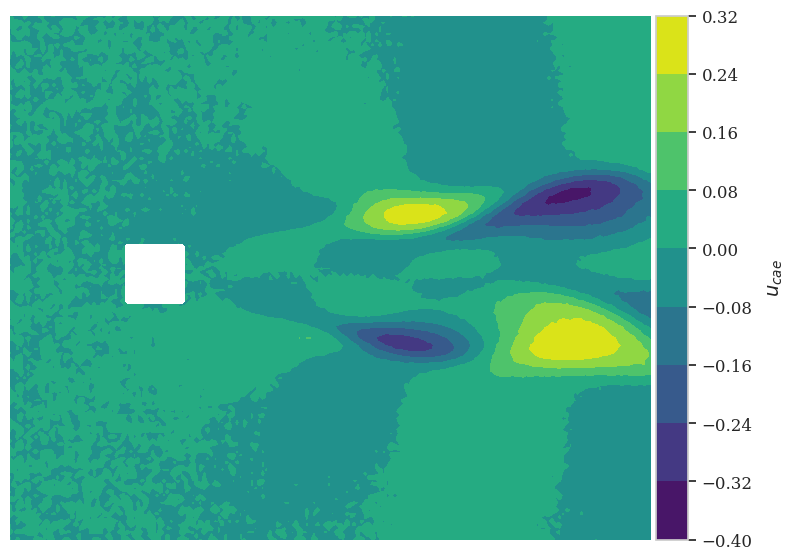

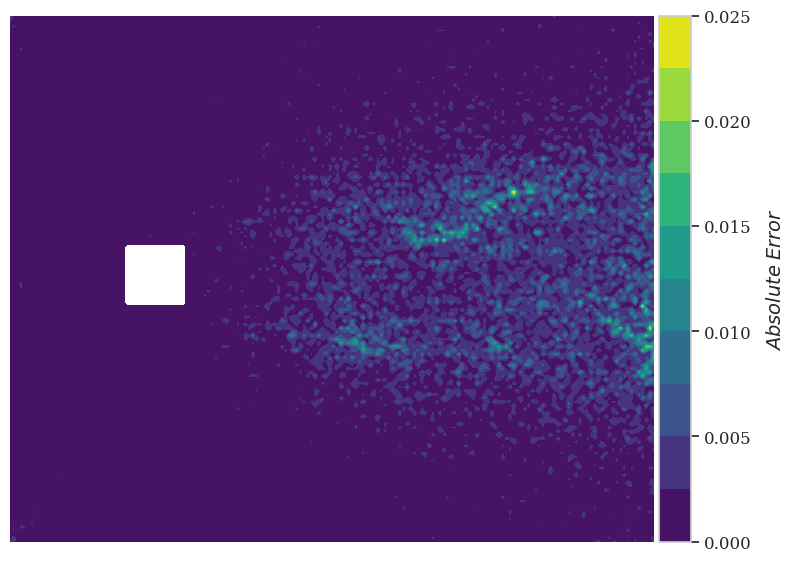

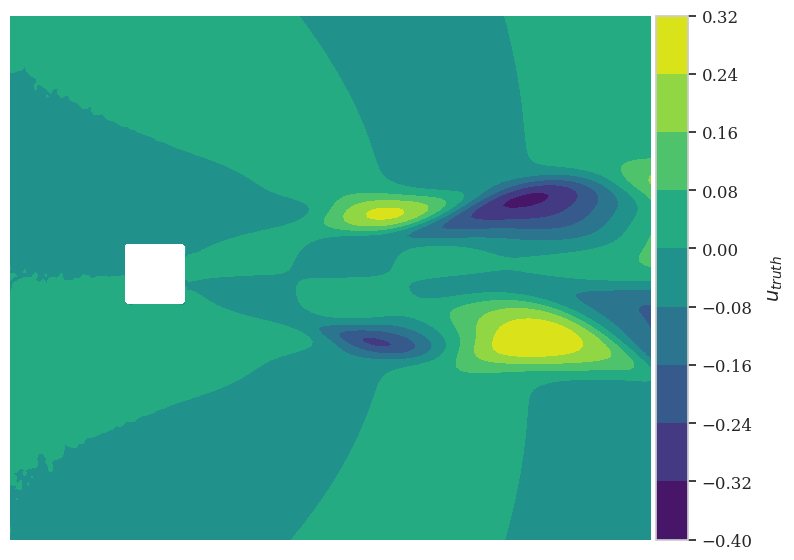

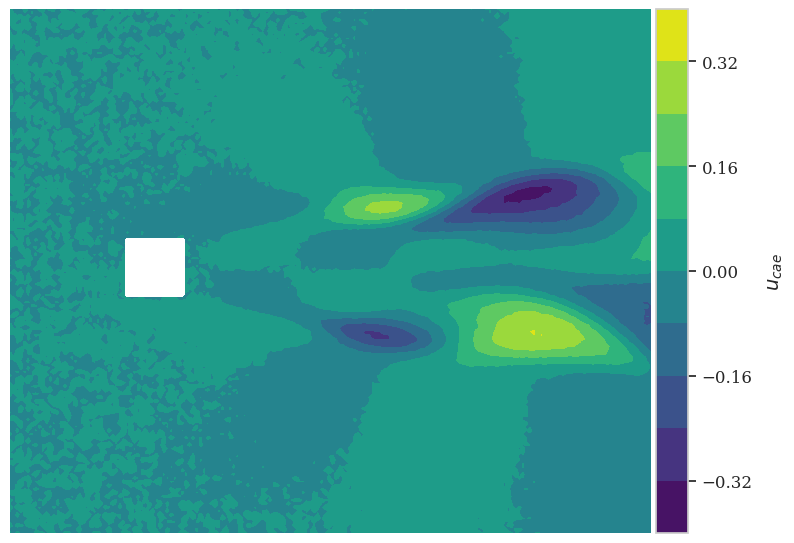

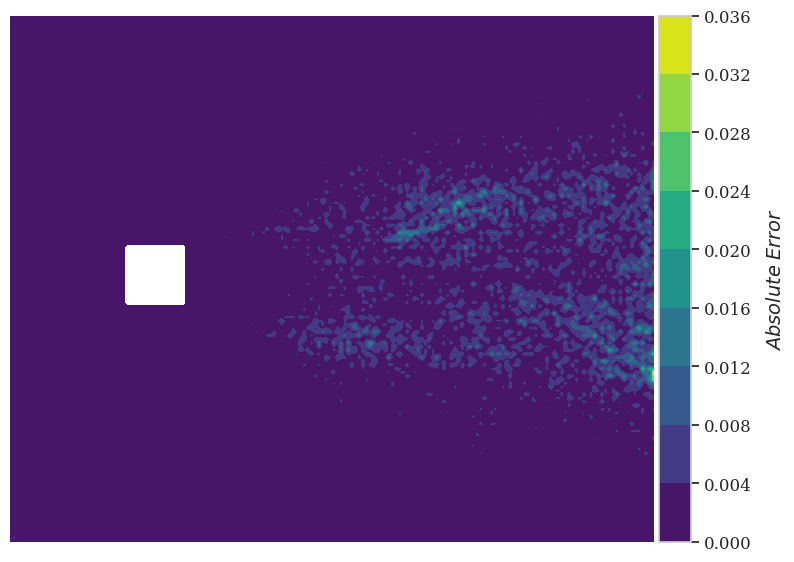

In [24]:
# plot CAE reconstruct result
skip = 99
for i in range(2):
    utrue = U_test[i*skip:i*skip+1].copy()
    ucae = model(utrue,a,b)[1].numpy()
    uerror  = np.abs(ucae-utrue)
    plot_contour(utrue[0][:,:,0],c=r'$u_{truth}$',filename=path+'/figures/'+f'utrue{i+1}.pdf')
    plot_contour(ucae[0][:,:,0],c=r'$u_{cae}$',filename=path+'/figures/'+f'ucae{i+1}.pdf')
    plot_contour(uerror[0][:,:,0],c=r'$Absolute \; Error$',filename=path+'/figures/'+f'uerror{i+1}.pdf')

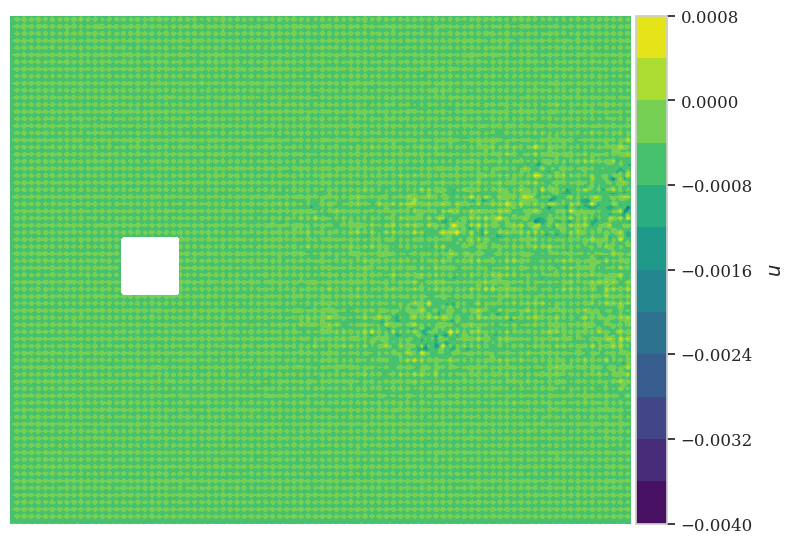

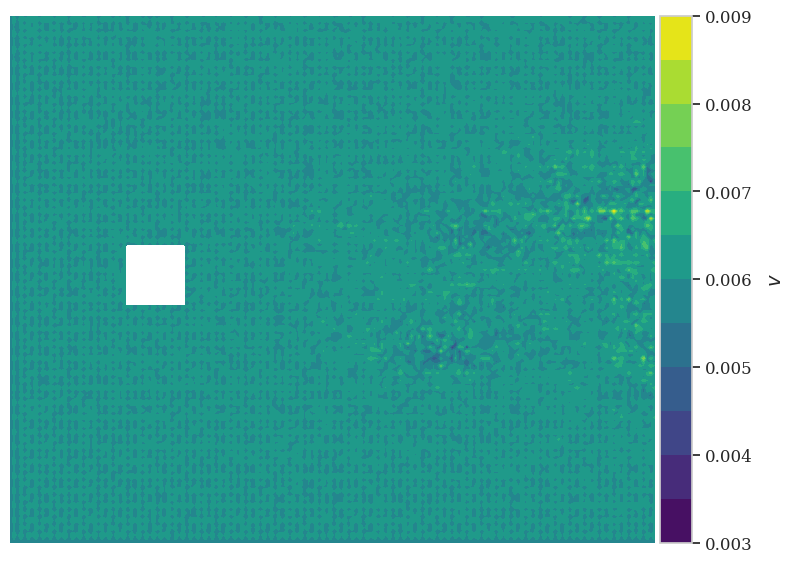

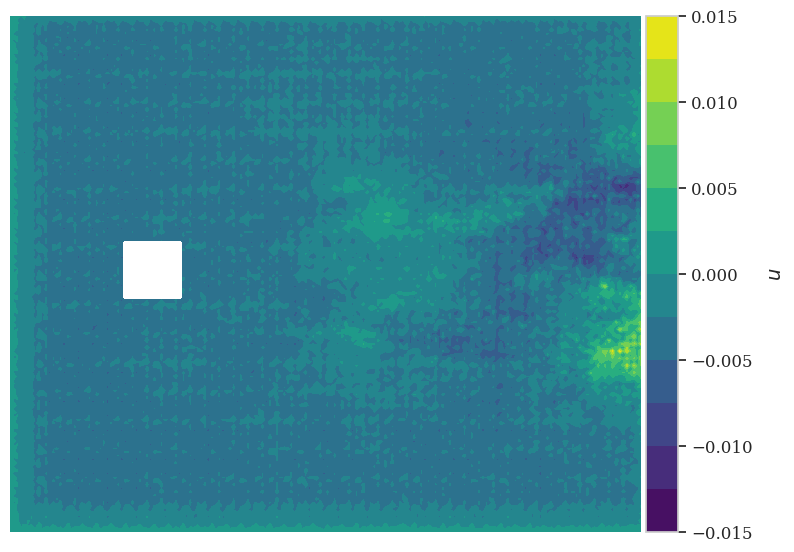

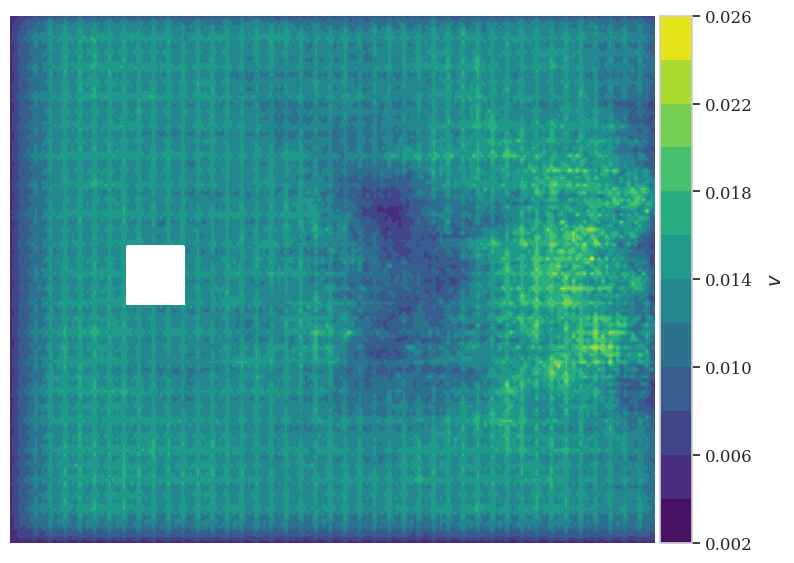

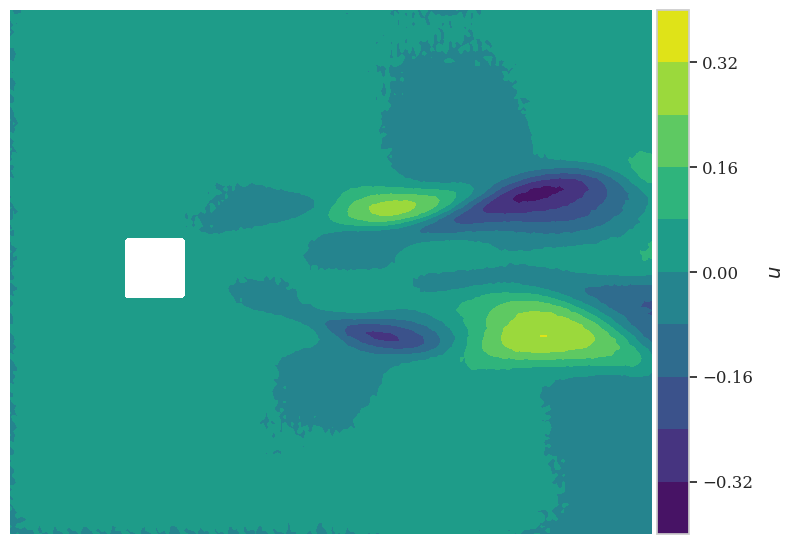

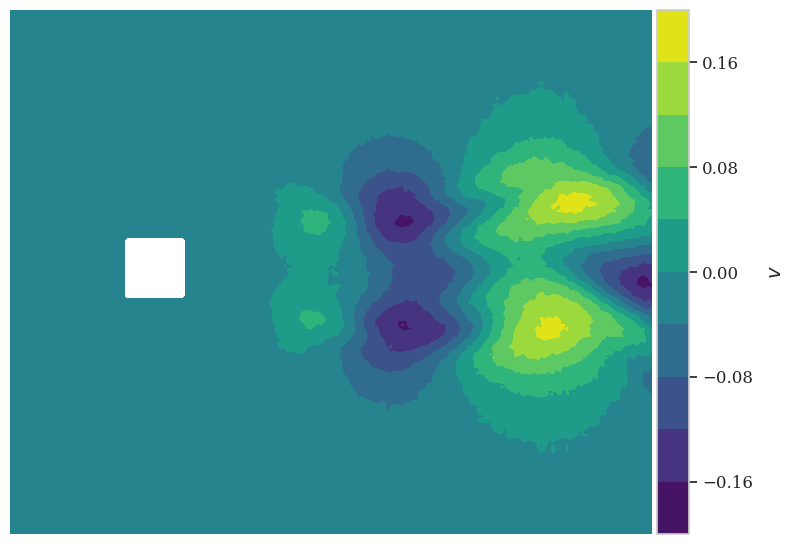

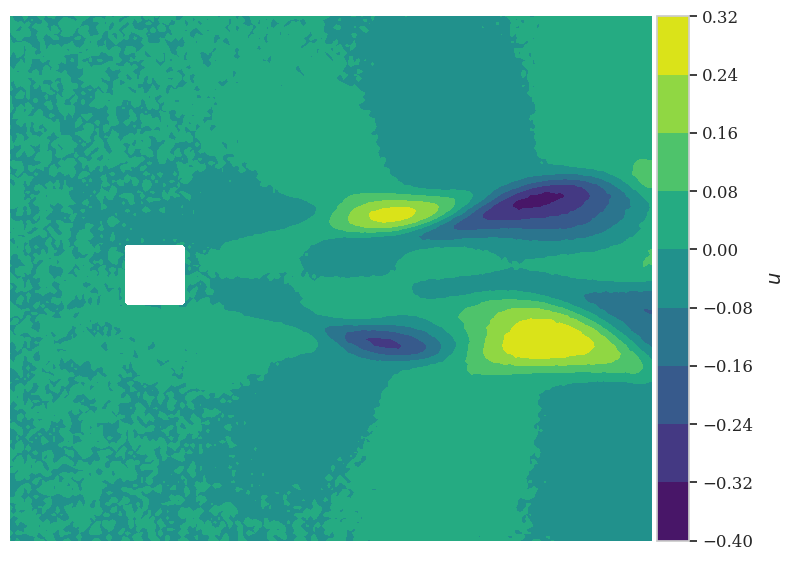

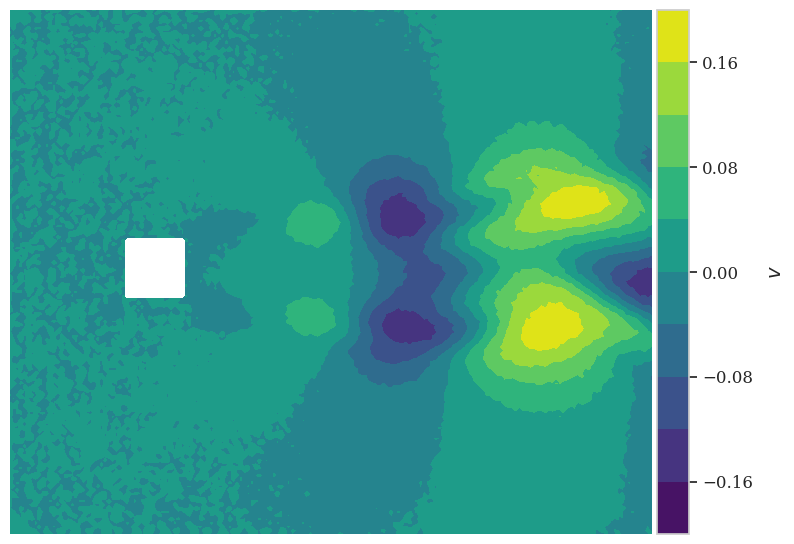

In [35]:
# plot different decoder's result
utrue = U_test[100:101].copy()
dec_outs, recons = get_decoders_output(utrue, a, b)
for i in range(len(dec_outs)):
    plot_contour(dec_outs[i][0][:,:,0],c=r'$u$',filename=path+'/figures/'+f'dec{i+1}_t_u.pdf')
    plot_contour(dec_outs[i][0][:,:,1],c=r'$v$',filename=path+'/figures/'+f'dec{i+1}_t_v.pdf')

plot_contour(recons[0][:,:,0],c=r'$u$',filename=path+'/figures/'+f'recons_t_u.pdf')
plot_contour(recons[0][:,:,1],c=r'$v$',filename=path+'/figures/'+f'recons_t_v.pdf')

#test
#plot_contour(abs(recons[0][:,:,0]-dec_outs[2][0][:,:,0]),c=r'$u$',filename=path+'/figures/'+f'test.pdf')

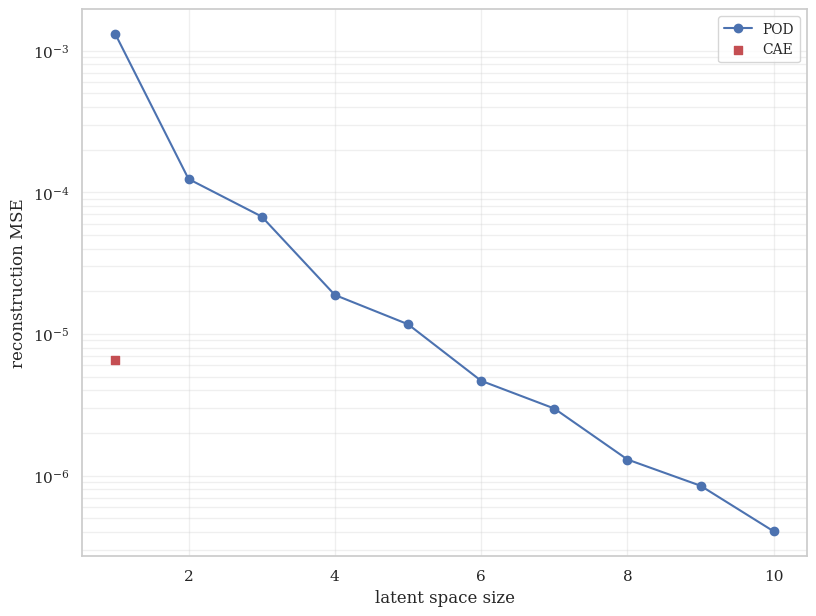

ek in 1 modes:  0.5054436248168349
ek in 2 modes:  0.9546054898388684
ek in 3 modes:  0.9753429620363749
ek in 4 modes:  0.993084213680122
ek in 5 modes:  0.9957024502794957
ek in 6 modes:  0.9982844020222547
ek in 7 modes:  0.9989064493421757
ek in 8 modes:  0.9995226746263506
ek in 9 modes:  0.9996885915116581
ek in 10 modes:  0.9998517500699381
CAE_ek:  0.9975954678544077


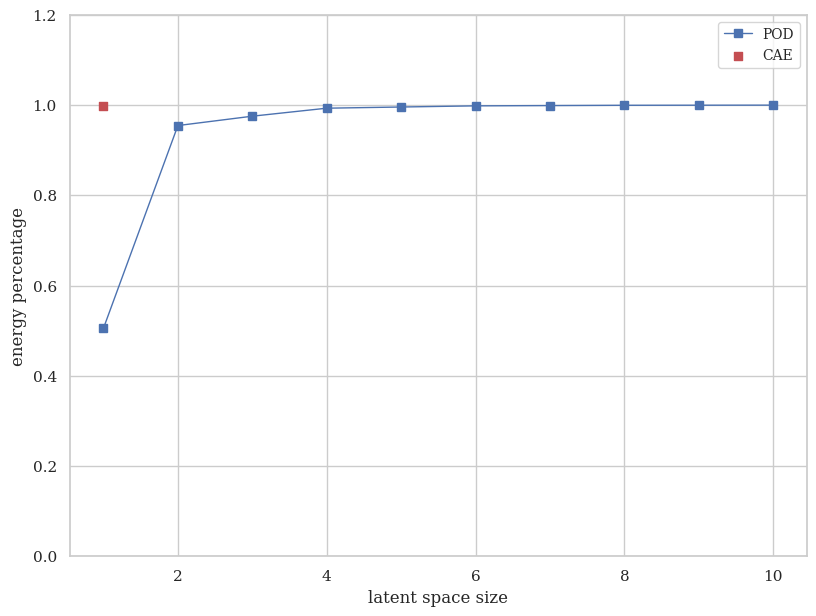

In [36]:
# plot reconstruct loss and energy loss of CAE and POD
test_data = U_test[-200:]
lenn = 10
skip = 1

POD_error = np.zeros(lenn)
for i in range(lenn):
    components, error, _, _, _, _ = POD_SVD(test_data, components=i*skip+1)
    POD_error[i]  = error #error between the input and reconstructed with POD

U_dec = model(test_data,a,b)[1].numpy()
CAE_error = mean_squared_error(U_dec.flatten(),test_data.flatten())

plt.figure(figsize=(8,6))
plt.plot(np.arange(lenn)*skip+1,POD_error,marker='o',label='POD')
plt.scatter(N_latent, CAE_error, c='r',label='CAE',marker='s')
plt.grid(True, axis="both", which='both', ls="-", alpha=0.3)
plt.ylabel('reconstruction MSE', fontsize=12)
plt.xlabel('latent space size', fontsize=12)
plt.yscale('log')
plt.legend(fontsize=10)
plt.tight_layout(pad=0.1)
plt.savefig(path+'/figures/'+'reconsLoss.pdf')
plt.show()


POD_ek = np.zeros(lenn)
for i in range(lenn):
    _, _, reconstructs, _, _, _ = POD_SVD(test_data, components=i*skip+1)
    POD_ek[i] = ek(reconstructs, test_data)
    print(f'ek in {i+1} modes: ', POD_ek[i])
    
CAE_ek = ek(U_dec, test_data)
print('CAE_ek: ', CAE_ek)

plt.figure(figsize=(8,6))
plt.plot(np.arange(lenn)*skip+1, POD_ek, '-sb', label='POD', linewidth=1)
plt.scatter(N_latent, CAE_ek, c='r',label='CAE',marker='s')
plt.grid(True)
#plt.title('total energy in mode')
plt.xlabel('latent space size', fontsize=12)
plt.ylabel('energy percentage', fontsize=12)
plt.legend(fontsize=10)
#plt.xlim([0, 11])
plt.ylim([0, 1.2])
plt.tight_layout(pad=0.1)
plt.savefig(path+'/figures/'+'energyLoss.pdf')
plt.show()

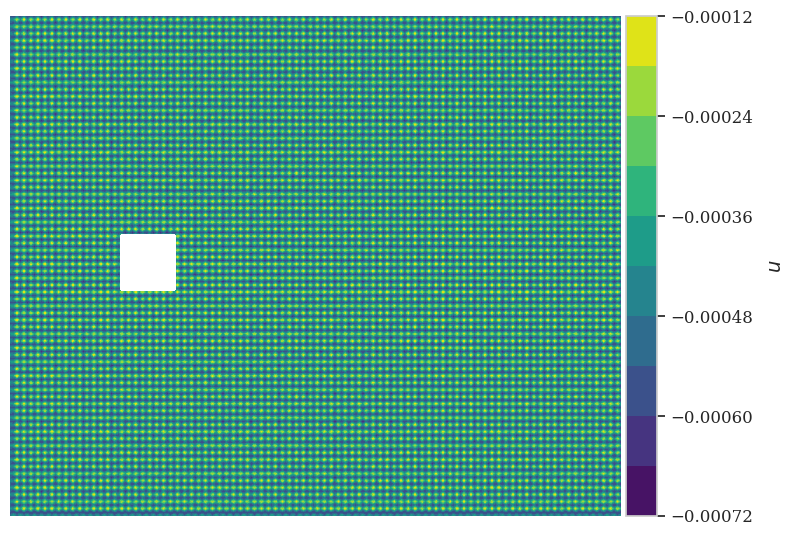

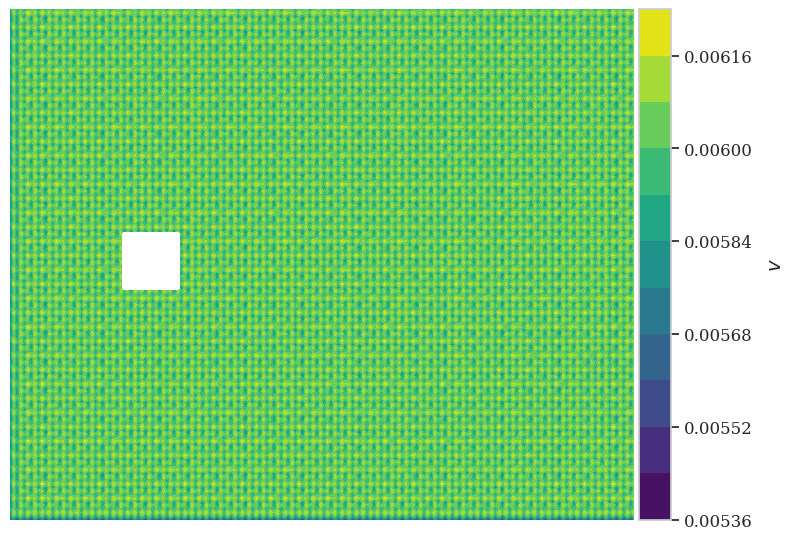

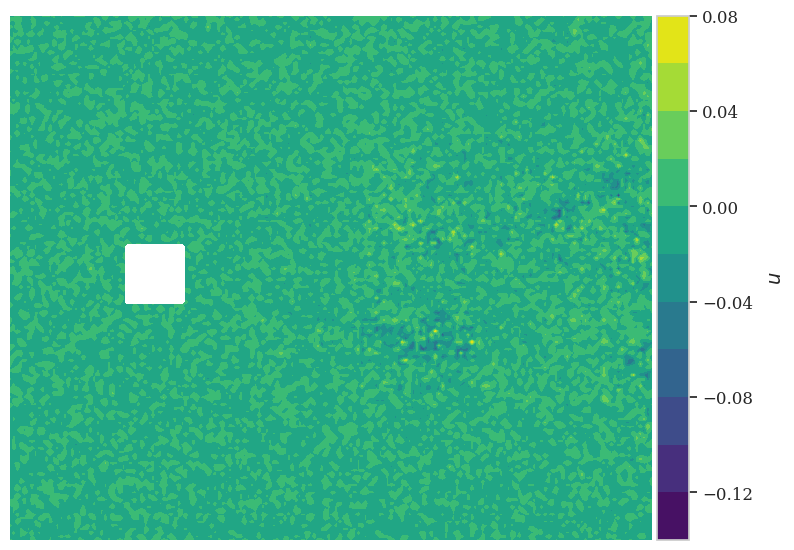

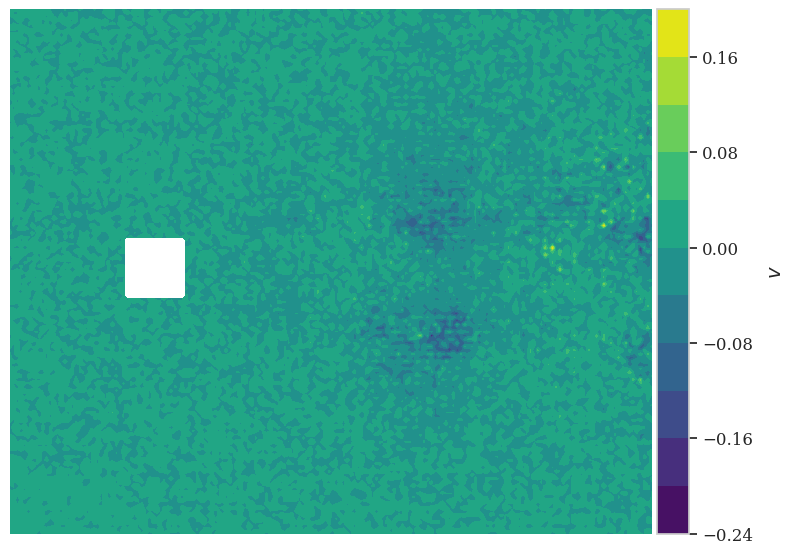

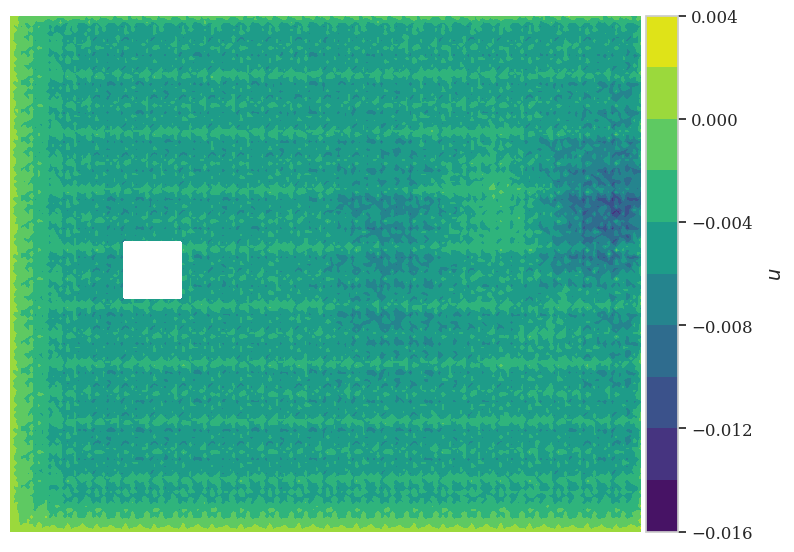

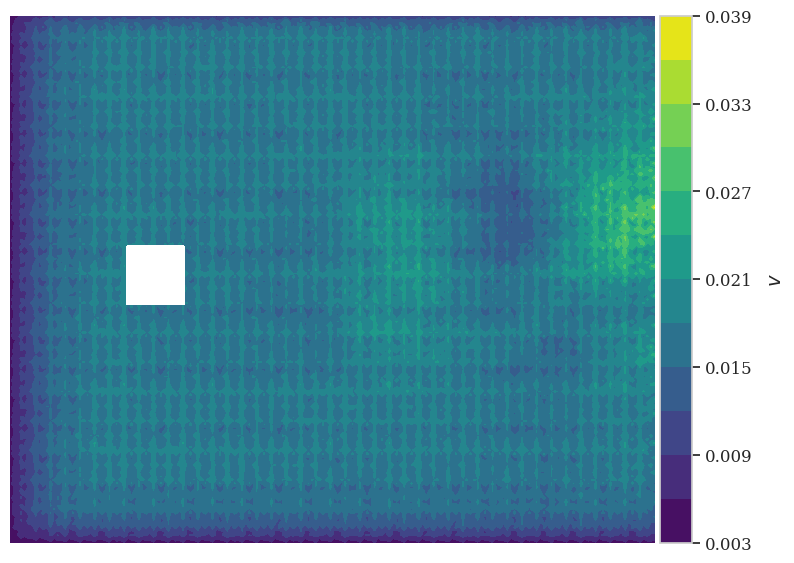

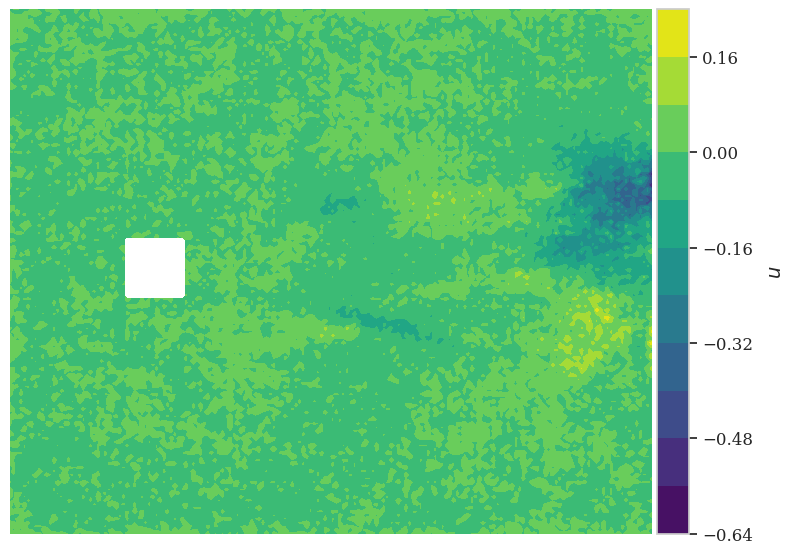

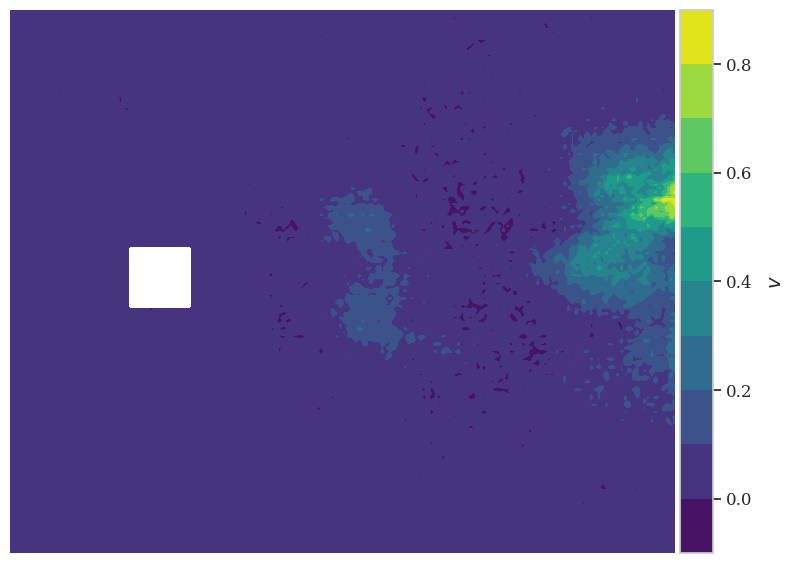

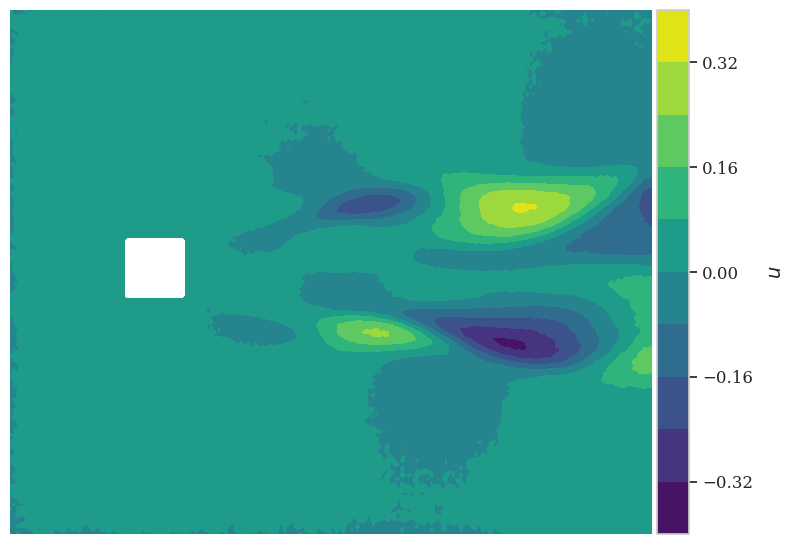

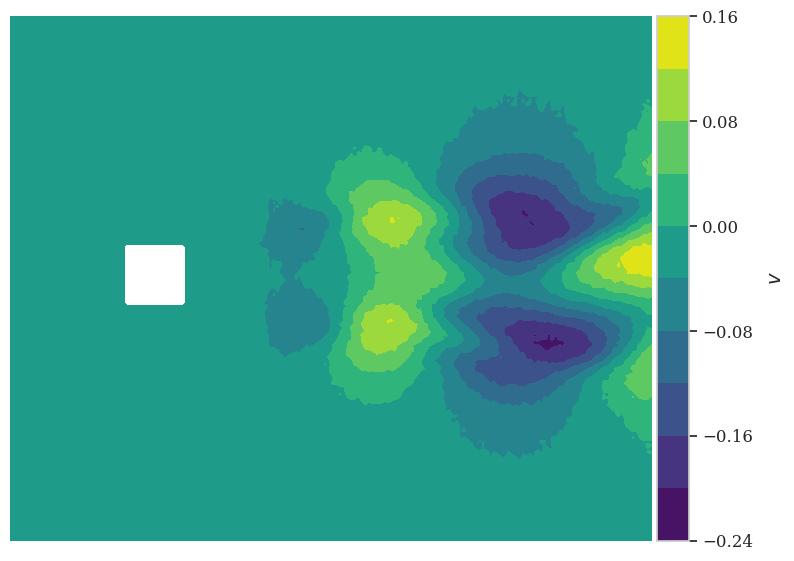

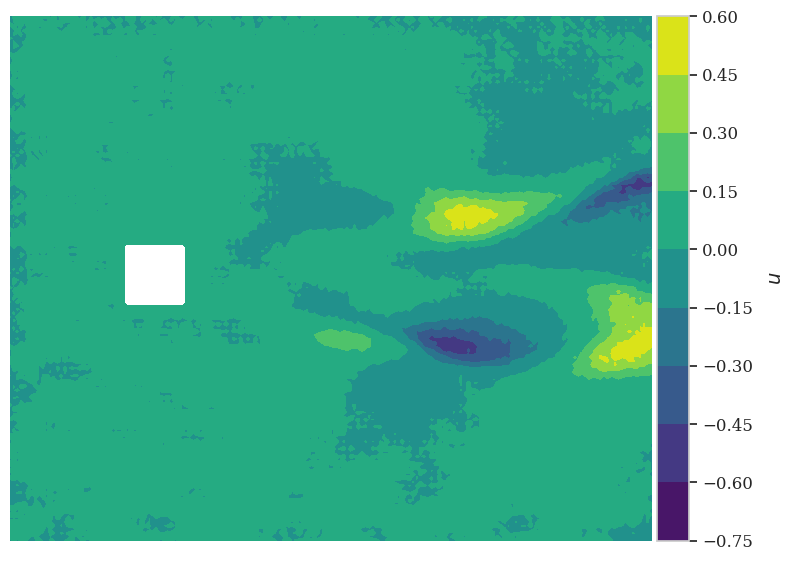

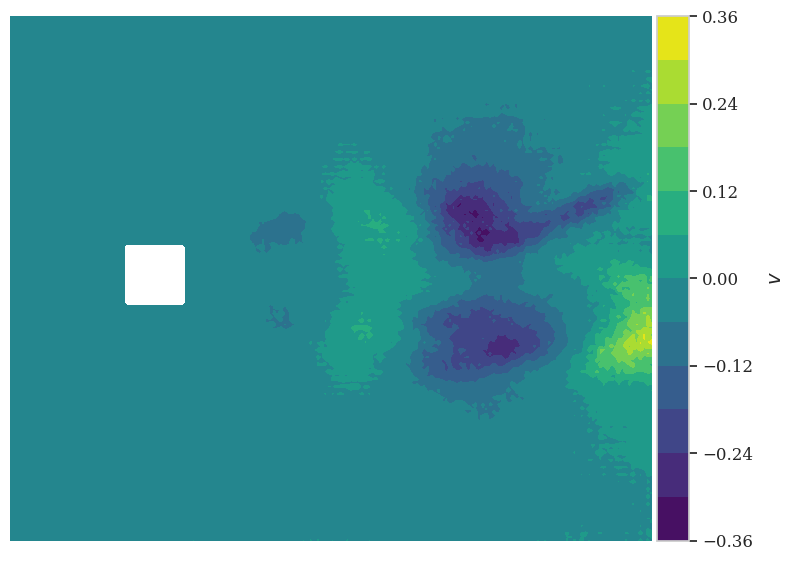

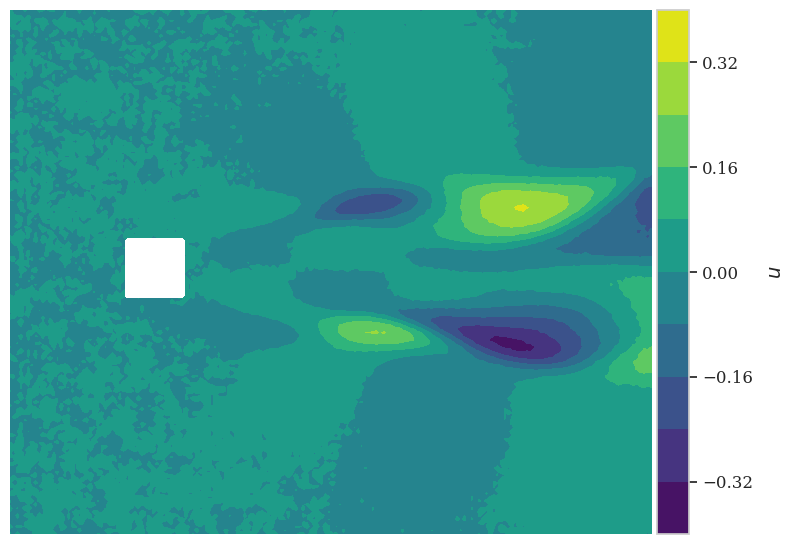

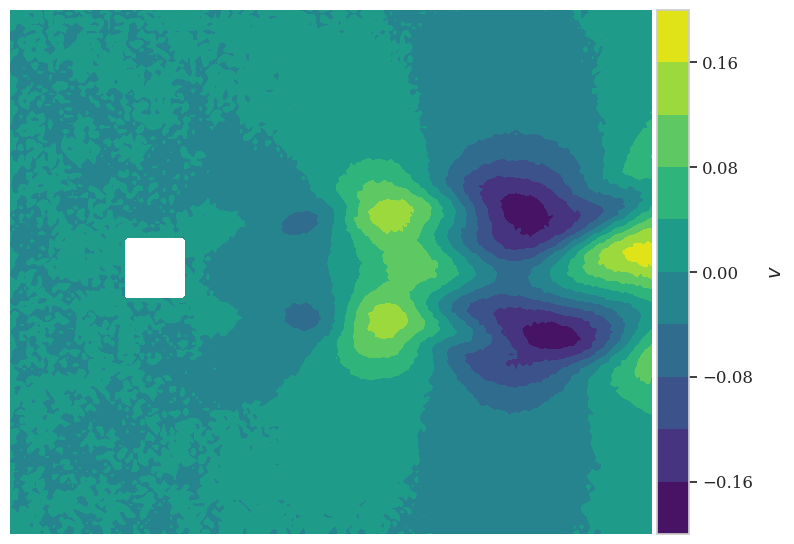

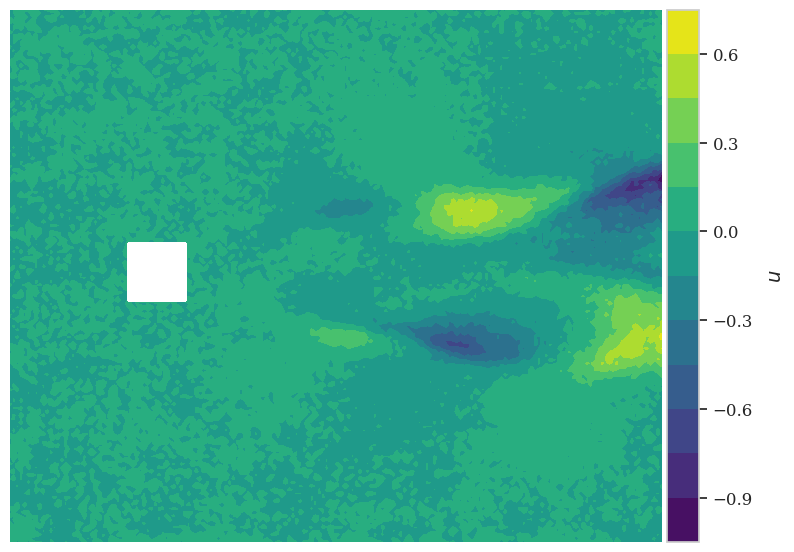

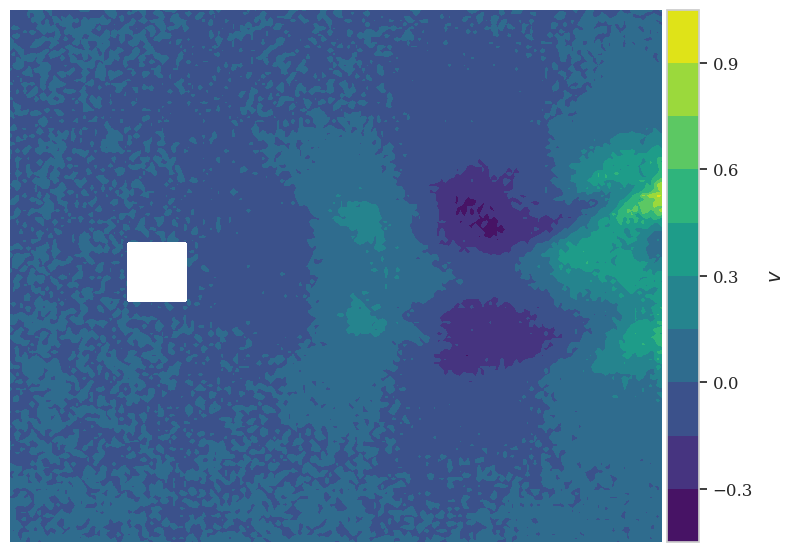

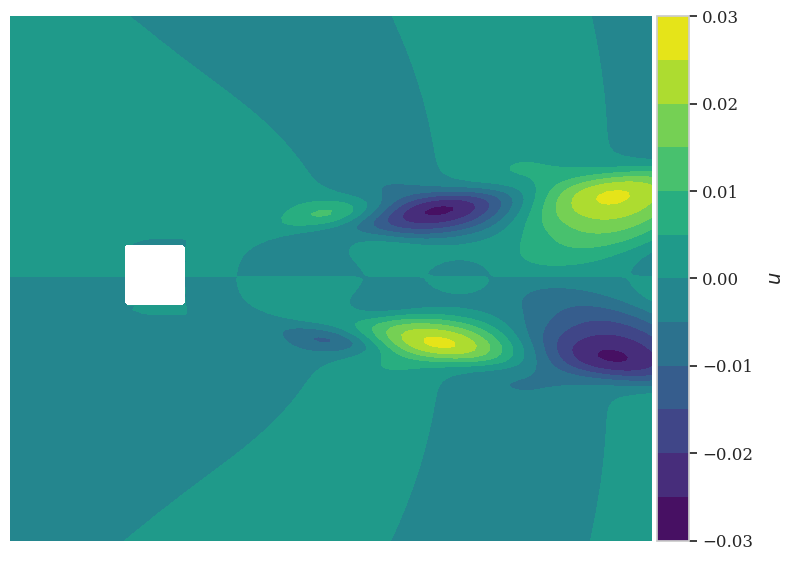

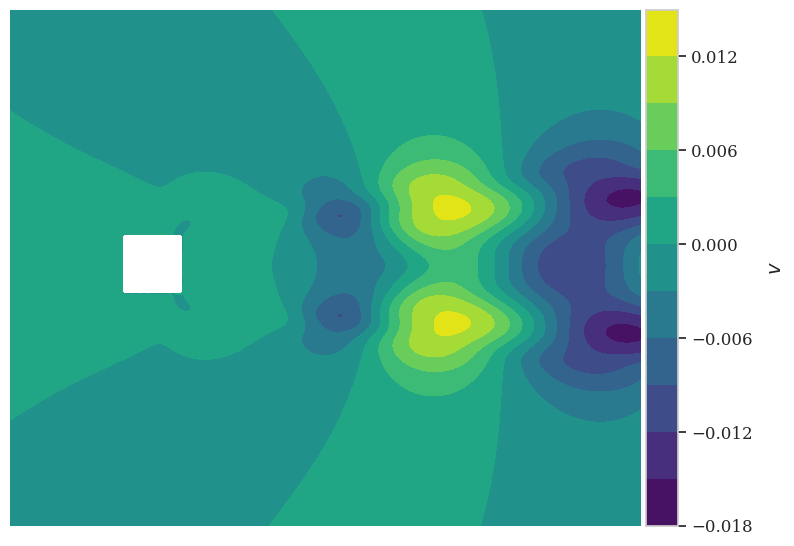

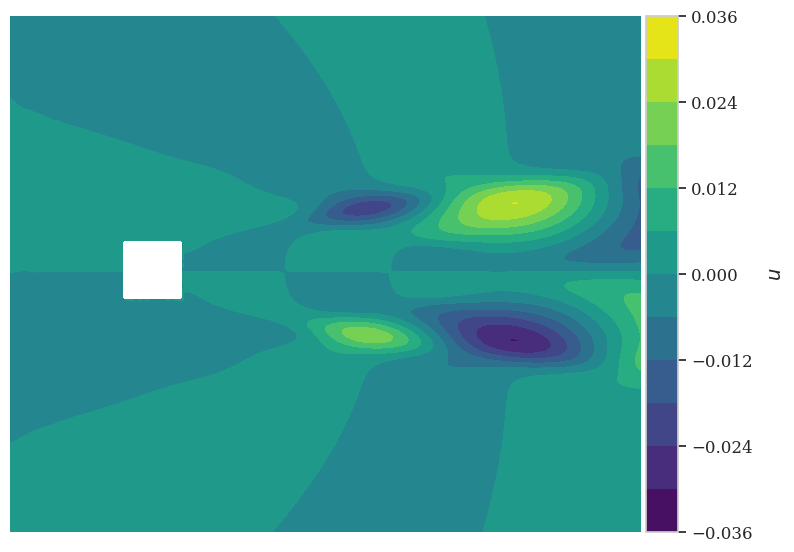

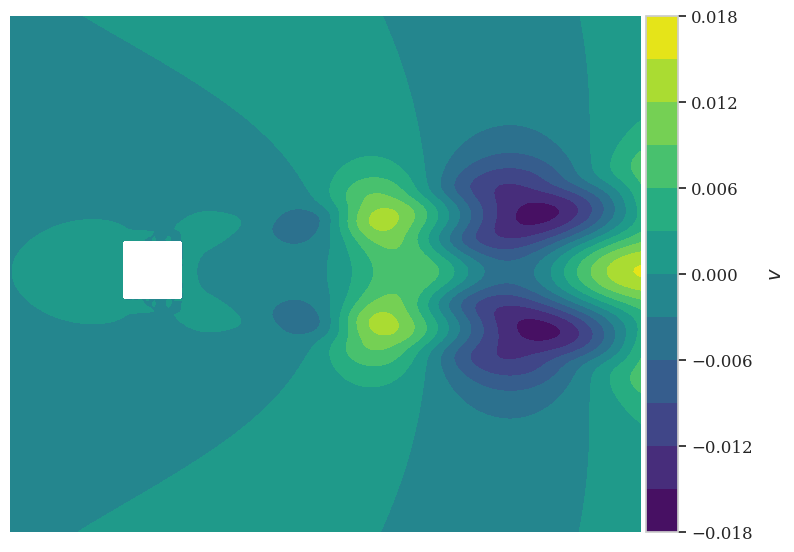

In [37]:
# plot the CAE and POD modes
latentModeCoeffs = np.array([
                    [0],
                    [1]
                ])

decoderOutputs, CAEModes = get_reconstruct(latentModeCoeffs,b)

_, _, _, _, PODModes, PODModesCoeffs = POD_SVD(test_data,lenn)

for i in range(len(decoderOutputs)):
    plot_contour(decoderOutputs[i][0][:,:,0],c=r'$u$',filename=path+'/figures/'+f'dec{i+1}_0_u.pdf')
    plot_contour(decoderOutputs[i][0][:,:,1],c=r'$v$',filename=path+'/figures/'+f'dec{i+1}_0_v.pdf')
    plot_contour(decoderOutputs[i][1][:,:,0],c=r'$u$',filename=path+'/figures/'+f'dec{i+1}_1_u.pdf')
    plot_contour(decoderOutputs[i][1][:,:,1],c=r'$v$',filename=path+'/figures/'+f'dec{i+1}_1_v.pdf')
    
# CAE mode
plot_contour(CAEModes[0][:,:,0],c=r'$u$',filename=path+'/figures/'+f'CAEMode0_u.pdf')
plot_contour(CAEModes[0][:,:,1],c=r'$v$',filename=path+'/figures/'+f'CAEMode0_v.pdf')
plot_contour(CAEModes[1][:,:,0],c=r'$u$',filename=path+'/figures/'+f'CAEMode1_u.pdf')
plot_contour(CAEModes[1][:,:,1],c=r'$v$',filename=path+'/figures/'+f'CAEMode1_v.pdf')

# POD mode
plot_contour(PODModes[0][:,:,0],c=r'$u$',filename=path+'/figures/'+f'PODMode0_u.pdf')
plot_contour(PODModes[0][:,:,1],c=r'$v$',filename=path+'/figures/'+f'PODMode0_v.pdf')
plot_contour(PODModes[1][:,:,0],c=r'$u$',filename=path+'/figures/'+f'PODMode1_u.pdf')
plot_contour(PODModes[1][:,:,1],c=r'$v$',filename=path+'/figures/'+f'PODMode1_v.pdf')


CAEModesCoeffs.shape:  (200, 1)
CAEModesCoeffs range: -0.44268882 0.09522499
PODMode 1 Coeffs range: -11.945798 11.993931
PODMode 2 Coeffs range: -11.025838 10.974258


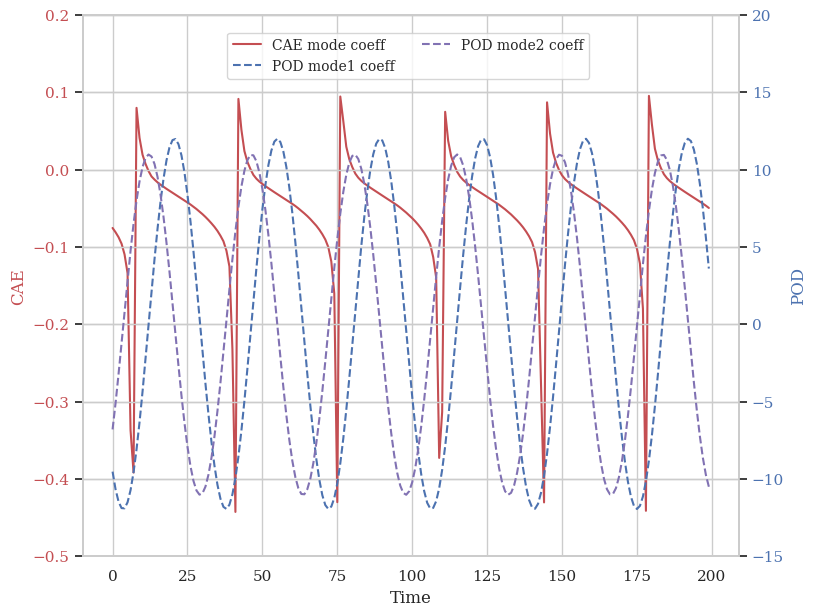

Dominant Frequency: 0.0 Hz
Dominant Frequency: 1.2000000000000002 Hz
Dominant Frequency: 1.2000000000000002 Hz


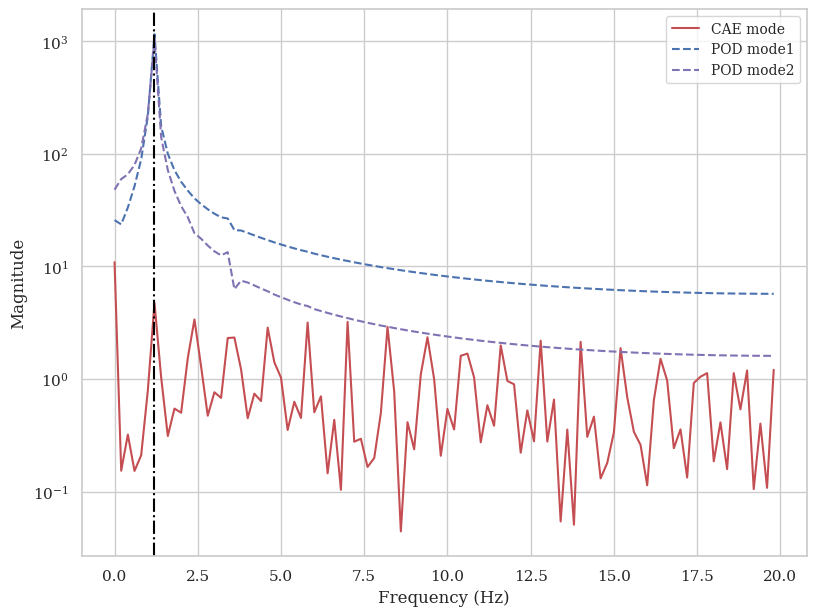

In [40]:
# CAE and POD modeCoeffs comparing
CAEModesCoeffs = get_latent(test_data,a)
print('CAEModesCoeffs.shape: ',CAEModesCoeffs.shape)
lat1max = np.max(CAEModesCoeffs[:,0])
lat1min = np.min(CAEModesCoeffs[:,0])
print('CAEModesCoeffs range:', lat1min, lat1max)

mode1max = np.max(PODModesCoeffs[:,0])
mode1min = np.min(PODModesCoeffs[:,0])
mode2max = np.max(PODModesCoeffs[:,1])
mode2min = np.min(PODModesCoeffs[:,1])
print('PODMode 1 Coeffs range:', mode1min, mode1max)
print('PODMode 2 Coeffs range:', mode2min, mode2max)


# coeffs time figure
fig, ax1 = plt.subplots(figsize=(8,6))

ax1.plot(CAEModesCoeffs[:,0], 'r-', label='CAE mode coeff')
ax1.set_xlabel('Time',fontsize=12)
ax1.set_ylabel('CAE', color='r',fontsize=12)
ax1.tick_params(axis='y', labelcolor='r')
ax1.set_ylim(-0.5,0.2)

ax2 = ax1.twinx()
ax2.plot(PODModesCoeffs[:,0], 'b--', label='POD mode1 coeff')
ax2.plot(PODModesCoeffs[:,1], 'm--', label='POD mode2 coeff')
ax2.set_ylabel('POD', color='b',fontsize=12)
ax2.tick_params(axis='y', labelcolor='b')
ax2.set_ylim(-15,20)
#fig.legend(loc="upper center", bbox_to_anchor=(0.5,0.87), ncol=2)
fig.legend(loc="upper center", bbox_to_anchor=(0.5,0.97), ncol=2, fontsize=10)
plt.tight_layout(pad=0.1)
plt.savefig(path+'/figures/'+'modesCoeffs_t.pdf')
plt.show()


fs1 = freqSpectrum(CAEModesCoeffs[:,0])
fs3 = freqSpectrum(PODModesCoeffs[:,0])
fs4 = freqSpectrum(PODModesCoeffs[:,1])

# coeffs spectrum figure
plt.figure(figsize=(8,6))
plt.plot(fs1[0],fs1[1], 'r-', label='CAE mode')
#plt.plot(fs2[0],fs2[1], 'g-', label='CAE mode2')
plt.plot(fs3[0],fs3[1], 'b--', label='POD mode1')
plt.plot(fs4[0],fs4[1], 'm--', label='POD mode2')
plt.axvline(x=fs3[2], color='black', linestyle='-.') #, label=f'Dominant Frequency: {dominant_frequency} Hz')
plt.yscale('log')
#plt.title('Frequency Spectrum')
plt.xlabel('Frequency (Hz)',fontsize=12)
plt.ylabel('Magnitude',fontsize=12)
plt.legend(fontsize=10)
plt.grid(True)
plt.tight_layout(pad=0.1)
plt.savefig(path+'/figures/'+'modesCoeffs_f.pdf')
plt.show()


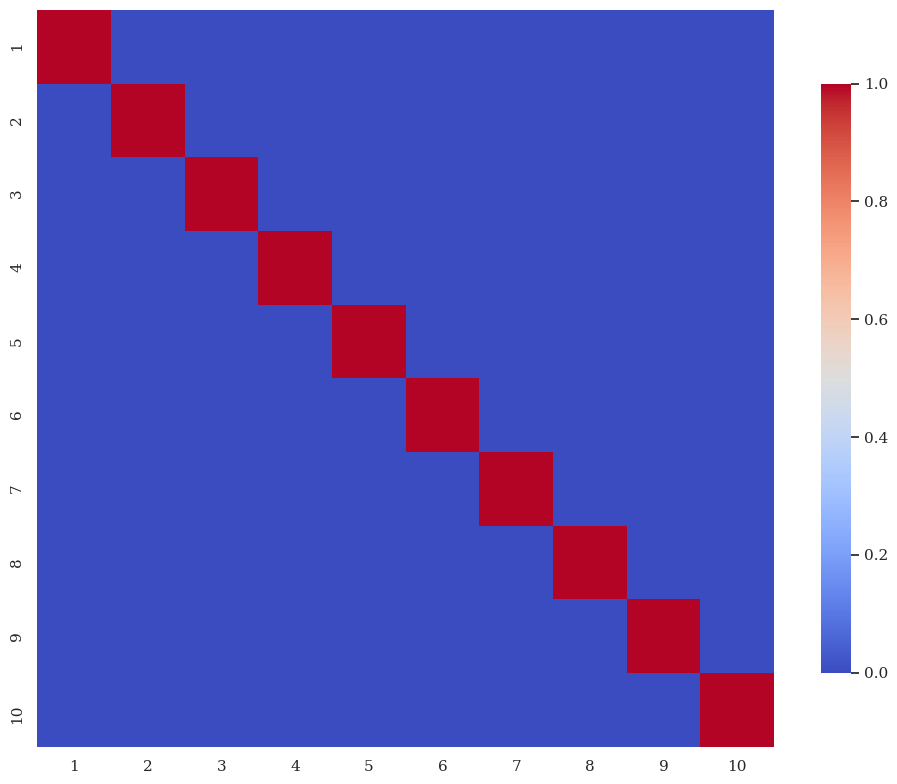

In [50]:
plot_heatmap(PODModesCoeffs, annotion=False, filename=path+'/figures/'+f'PODheatmap.pdf')

CAEModesCoeffs & PODModesCoeffs1:  0.3768933694364613
CAEModesCoeffs & PODModesCoeffs2:  0.1469417956406294
CAEModesCoeffs & PODModesCoeffs3:  -0.3121127099595969
CAEModesCoeffs & PODModesCoeffs4:  -0.10136198541579375
CAEModesCoeffs & PODModesCoeffs5:  -0.24701431278125635
CAEModesCoeffs & PODModesCoeffs6:  0.18424470188372852
CAEModesCoeffs & PODModesCoeffs7:  0.036747550653921164
CAEModesCoeffs & PODModesCoeffs8:  -0.28537559477126984
CAEModesCoeffs & PODModesCoeffs9:  0.13914956199259923
CAEModesCoeffs & PODModesCoeffs10:  -0.2289347140332206


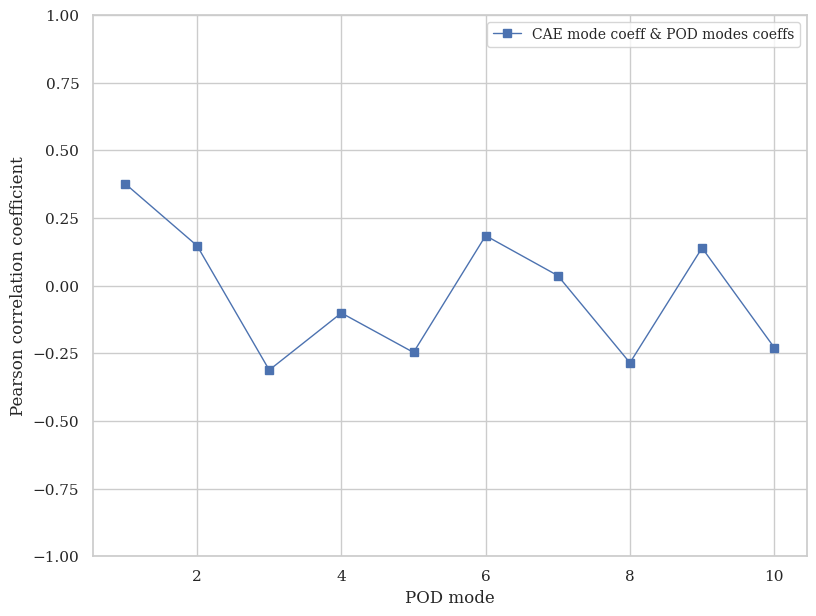

CAEModesCoeffs & PODModesCoeffs1: Spearman cor: 0.4943433585839646 ; p value: 1.0112543879271004e-13
CAEModesCoeffs & PODModesCoeffs2: Spearman cor: 0.6230510762769071 ; p value: 6.761329821921648e-23
CAEModesCoeffs & PODModesCoeffs3: Spearman cor: -0.35519687992199805 ; p value: 2.4557512780977314e-07
CAEModesCoeffs & PODModesCoeffs4: Spearman cor: 0.09602790069751745 ; p value: 0.1761657462187141
CAEModesCoeffs & PODModesCoeffs5: Spearman cor: -0.25333683342083557 ; p value: 0.00029518136069832504
CAEModesCoeffs & PODModesCoeffs6: Spearman cor: 0.06072601815045377 ; p value: 0.3929934738165072
CAEModesCoeffs & PODModesCoeffs7: Spearman cor: 0.11268581714542865 ; p value: 0.11212960763430511
CAEModesCoeffs & PODModesCoeffs8: Spearman cor: -0.16585614640366012 ; p value: 0.018918260298294604
CAEModesCoeffs & PODModesCoeffs9: Spearman cor: 0.1244926123153079 ; p value: 0.07902096077800431
CAEModesCoeffs & PODModesCoeffs10: Spearman cor: -0.09383784594614866 ; p value: 0.1862788487479122

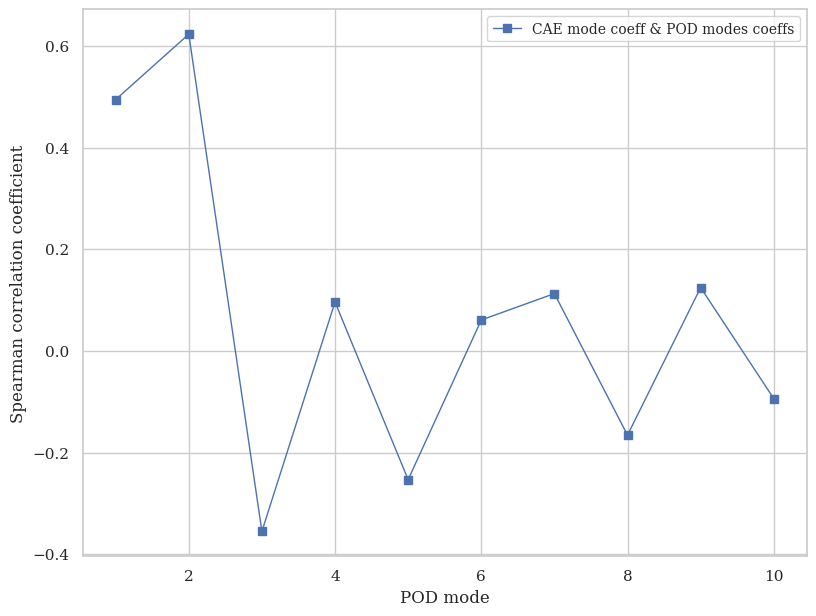

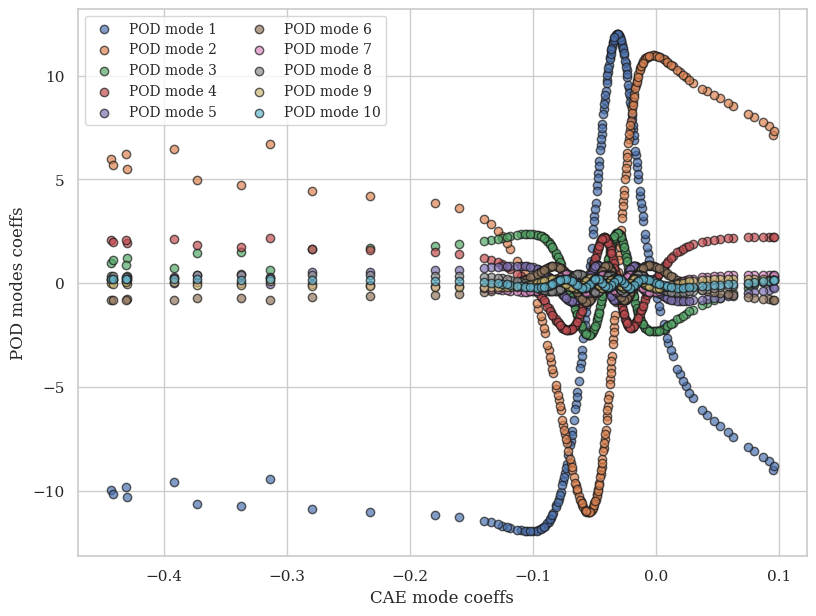

'\n# mutual information\nfrom scipy.stats import entropy\ndef mutual_information(x, y, bins=10):\n    # 使用直方图估计概率密度，计算互信息 \n    joint_hist, _, _ = np.histogram2d(x, y, bins=bins)\n    joint_prob = joint_hist / np.sum(joint_hist)\n    x_prob = np.sum(joint_prob, axis=1, keepdims=True)\n    y_prob = np.sum(joint_prob, axis=0, keepdims=True)\n\n    mi = np.nansum(joint_prob * np.log(joint_prob / (x_prob @ y_prob)))\n    return mi\n\nmi = np.zeros(PODModesCoeffs.shape[1])\n\nfor i in range(PODModesCoeffs.shape[1]):\n    mi[i] = mutual_information(CAEModesCoeffs[:,0], PODModesCoeffs[:,i], bins=10)\n    print(f"CAEModesCoeffs & PODModesCoeffs{i+1} mutual information: {mi[i]}")\n'

In [52]:
# pilson correlation
correlation = np.zeros(PODModesCoeffs.shape[1])

for i in range(PODModesCoeffs.shape[1]):
    correlation[i] = np.corrcoef(CAEModesCoeffs[:, 0], PODModesCoeffs[:, i])[0,1]  
    print(f"CAEModesCoeffs & PODModesCoeffs{i+1}: ", correlation[i])

# coeffs correlation figure
xx = np.linspace(1,PODModesCoeffs.shape[1],PODModesCoeffs.shape[1])
#plt.rcParams["font.size"] = 15
plt.figure(figsize=(8,6))
plt.plot(xx, correlation, color='b', marker='s', linewidth=1, label='CAE mode coeff & POD modes coeffs')
#plt.plot(xx, correlation2, color='blue', linewidth=0.5, label='CAE coeff2 & POD coeffs')
plt.ylim([-1,1])
plt.legend(loc='upper right', prop={'size': 10})
plt.xlabel('POD mode', fontsize=12)
plt.ylabel('Pearson correlation coefficient', fontsize=12)
#plt.title('the correlation coefficient between CAE coeffs and POD mode coeffs')
plt.tight_layout(pad=0.1)
plt.savefig(path+'/figures/'+'modesCoeffs_pearsoncor.pdf')
plt.show()


# spearman correlation
from scipy.stats import spearmanr
spear_cor = np.zeros(PODModesCoeffs.shape[1])
p = np.zeros(PODModesCoeffs.shape[1])

for i in range(PODModesCoeffs.shape[1]):
    spear_cor[i], p[i] = spearmanr(CAEModesCoeffs[:,0], PODModesCoeffs[:,i])
    print(f"CAEModesCoeffs & PODModesCoeffs{i+1}: Spearman cor: {spear_cor[i]} ; p value: {p[i]}")

xx = np.linspace(1,PODModesCoeffs.shape[1],PODModesCoeffs.shape[1])
#plt.rcParams["font.size"] = 15
plt.figure(figsize=(8,6))
plt.plot(xx, spear_cor, color='b', marker='s', linewidth=1, label='CAE mode coeff & POD modes coeffs')
#plt.plot(xx, correlation2, color='blue', linewidth=0.5, label='CAE coeff2 & POD coeffs')
plt.legend(loc='upper right', prop={'size': 10})
plt.xlabel('POD mode', fontsize=12)
plt.ylabel('Spearman correlation coefficient', fontsize=12)
#plt.title('the correlation coefficient between CAE coeffs and POD mode coeffs')
plt.tight_layout(pad=0.1)
plt.savefig(path+'/figures/'+'modesCoeffs_spearmancor.pdf')
plt.show()


# scatter plot
plt.figure(figsize=(8, 6))
for i in range(PODModesCoeffs.shape[1]):
    plt.scatter(CAEModesCoeffs[:,0], PODModesCoeffs[:,i], alpha=0.7, edgecolor='k', label=f"POD mode {i+1}")
plt.xlabel("CAE mode coeffs")
plt.ylabel("POD modes coeffs")
#plt.title("Scatter Plot of Two Time Series")
plt.legend(loc='upper left', ncol=2, fontsize=10)
plt.grid(True)
plt.tight_layout(pad=0.1)
plt.savefig(path+'/figures/'+'modesCoeffs_scatter.pdf')
plt.show()


"""
# mutual information
from scipy.stats import entropy
def mutual_information(x, y, bins=10):
    # 使用直方图估计概率密度，计算互信息 
    joint_hist, _, _ = np.histogram2d(x, y, bins=bins)
    joint_prob = joint_hist / np.sum(joint_hist)
    x_prob = np.sum(joint_prob, axis=1, keepdims=True)
    y_prob = np.sum(joint_prob, axis=0, keepdims=True)

    mi = np.nansum(joint_prob * np.log(joint_prob / (x_prob @ y_prob)))
    return mi

mi = np.zeros(PODModesCoeffs.shape[1])

for i in range(PODModesCoeffs.shape[1]):
    mi[i] = mutual_information(CAEModesCoeffs[:,0], PODModesCoeffs[:,i], bins=10)
    print(f"CAEModesCoeffs & PODModesCoeffs{i+1} mutual information: {mi[i]}")
"""